In [1]:
from utils_sbm import *
from utils_clustering1d import *
from clustering1d import *
from vem import *

import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from graph_tool.all import *

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import k_means, SpectralClustering

from sknetwork.embedding import GSVD, Spectral, LaplacianEmbedding
from sknetwork.data import erdos_renyi
from sknetwork.visualization import svg_graph
from sknetwork.clustering import modularity, Louvain, KMeans
from IPython.display import SVG

from rpy2.robjects.packages import importr
import rpy2

### Utils

In [2]:
def our_clustering(adjacency,K=5,stop_cheat=True,true_labels=None,stop_var=False):
    cpt = -np.inf
    t = 0
    labels = []
    for j in range(1):
        start = time.time()
        fs = getIterateAverages(adjacency,d=K-1,K=K,stop_cheat=stop_cheat,
                                true_labels=true_labels,stop_var=stop_var)
        centroid,labels_k,inertia = k_means(fs[-1],K,n_init=5)
        t_alg = time.time()-start
        if inertia>cpt:
            cpt = inertia
            labels = labels_k
            t = t_alg
    return labels,t


def louvain(adjacency):
    labels = []
    cpt = -np.inf
    t = 0
    for j in range(1):
        start = time.time()
        louvain = Louvain()
        labels_louvain = louvain.fit_transform(adjacency)
        t_alg = time.time()-start
        
        mod = modularity(adjacency,labels_louvain)
        if (mod>cpt):
            cpt = mod
            labels = labels_louvain
            t = t_alg
    return labels,t


def spectralClustering(adjacency,K=5,emb="spectral"):
    start = time.time()
    if emb=="spectral":
        embedding = Spectral(K).fit_transform(adjacency)
    elif emb=="laplacian":
        embedding = LaplacianEmbedding(K).fit_transform(adjacency)
    else:
        embedding = GSVD(K).fit_transform(adjacency)
        
    centroid,labels_k,inertia = k_means(embedding,K,n_init=5)
    t = time.time()-start
    return labels_k,t


def mixer_vem(adj_spm,K=5):
    mixer = importr("mixer")
    rmixer = rpy2.robjects.r["mixer"]
    getModel = rpy2.robjects.r["getModel"]
    
    start = time.time()
    mix = rmixer(x=adj_spm,qmin=K,qmax=K,nbiter=1000,verbose=False)
    m = getModel(mix)
    labels = np.argmax(np.array(m[4]),axis=0)
    t = time.time()-start

    return labels,t


def mixer_ocem(adj_spm,K=5):
    mixer = importr("mixer")
    rmixer = rpy2.robjects.r["mixer"]
    getModel = rpy2.robjects.r["getModel"]
    
    cpt = -np.inf
    labels = []
    t = 0
    for j in range(1):        
        start = time.time()
        mix = rmixer(x=adj_spm,qmin=K,nbiter=100,verbose=False,method="classification")
        m = getModel(mix)
        labels_vem = np.argmax(np.array(m[4]),axis=0)
        t_vem = time.time()-start
        
        likelihood = m[1][0]
        if likelihood>cpt:
            cpt = likelihood
            labels = labels_vem[:]
            t = t_vem
    return labels,t


def my_vem(adjacency,K=5):
    cpt = -np.inf
    labels = []
    t = 0
    for j in range(5):
        start = time.time()
        vem = VEM(K)
        labels_vem = vem.fit(adjacency)
        t_vem = time.time()-start
        
        likelihood = vem.J()
        if likelihood>cpt:
            cpt = likelihood
            labels = labels_vem[:]
            t = t_vem
    return labels,t


def gt_em(adjacency,K=5):
    g = Graph(directed=False)
    edge_list = []
    for i in range(adjacency.shape[0]):
        for j in range(i):
            if adjacency[i,j]:
                edge_list.append((i,j))
    g.add_edge_list(edge_list)

    start = time.time()
    embedding = GSVD(K).fit_transform(adjacency)
    centroid,labels_k,inertia = k_means(embedding,K,n_init=5)

    state = EMBlockState(g,B=K,init_state=BlockState(g,b=labels_k))
    delta,niter = em_infer(state,verbose=False)
    labels_em = state.get_MAP().get_array()
    t = time.time()-start
    
    return labels_em,t

In [3]:
def plot_results(NMI_our,NMI_Louvain,NMI_Spec,NMI_VEM,ts_our,ts_Louvain,ts_Spec,ts_VEM):
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    
    betas = np.arange(0.45,0,-0.02)
    
    ax[0].plot(betas,np.mean(NMI_our,axis=0),color="red",label="Ours")
    ax[0].plot(betas,np.mean(NMI_Louvain,axis=0),color="blue",label="Louvain")
    ax[0].plot(betas,np.mean(NMI_Spec,axis=0),color="yellow",label="Spectral Clustering")
    ax[0].plot(betas,np.mean(NMI_VEM,axis=0),color="green",label="VEM")
    ax[0].fill_between(betas,np.mean(NMI_our,axis=0)+np.std(NMI_our,axis=0),
                       np.mean(NMI_our,axis=0)-np.std(NMI_our,axis=0),facecolor="red",alpha=0.5)
    ax[0].fill_between(betas,np.mean(NMI_Louvain,axis=0)+np.std(NMI_Louvain,axis=0),
                       np.mean(NMI_Louvain,axis=0)-np.std(NMI_Louvain,axis=0),facecolor="blue",alpha=0.5)
    ax[0].fill_between(betas,np.mean(NMI_Spec,axis=0)+np.std(NMI_Spec,axis=0),
                       np.mean(NMI_Spec,axis=0)-np.std(NMI_Spec,axis=0),facecolor="yellow",alpha=0.5)
    ax[0].fill_between(betas,np.mean(NMI_VEM,axis=0)+np.std(NMI_VEM,axis=0),
                       np.mean(NMI_VEM,axis=0)-np.std(NMI_VEM,axis=0),facecolor="green",alpha=0.5)
    
    ax[0].legend(loc="lower right")
    ax[0].set_title("Normalized Mutual Information")
    ax[0].set_ylabel("NMI")
    ax[0].set_xlabel(r"$\beta$")
    
    
    ax[1].plot(betas,np.mean(ts_our,axis=0),color="red",label="Ours")
    ax[1].plot(betas,np.mean(ts_Louvain,axis=0),color="blue",label="Louvain")
    ax[1].plot(betas,np.mean(ts_Spec,axis=0),color="yellow",label="Spectral Clustering")
    ax[1].plot(betas,np.mean(ts_VEM,axis=0),color="green",label="VEM")
    ax[1].fill_between(betas,np.mean(ts_our,axis=0)+np.std(ts_our,axis=0),
                       np.mean(ts_our,axis=0)-np.std(ts_our,axis=0),facecolor="red",alpha=0.5)
    ax[1].fill_between(betas,np.mean(ts_Louvain,axis=0)+np.std(ts_Louvain,axis=0),
                       np.mean(ts_Louvain,axis=0)-np.std(ts_Louvain,axis=0),facecolor="blue",alpha=0.5)
    ax[1].fill_between(betas,np.mean(ts_Spec,axis=0)+np.std(ts_Spec,axis=0),
                       np.mean(ts_Spec,axis=0)-np.std(ts_Spec,axis=0),facecolor="yellow",alpha=0.5)
    ax[1].fill_between(betas,np.mean(ts_VEM,axis=0)+np.std(ts_VEM,axis=0),
                       np.mean(ts_VEM,axis=0)-np.std(ts_VEM,axis=0),facecolor="green",alpha=0.5)
    
    ax[1].legend()
    ax[1].set_title("Time")
    ax[1].set_ylabel("t")
    ax[1].set_xlabel(r"$\beta$")
    
    plt.show()
    
    plt.plot(betas,np.mean(ts_our,axis=0),color="red",label="Ours")
    plt.plot(betas,np.mean(ts_Louvain,axis=0),color="blue",label="Louvain")
    plt.plot(betas,np.mean(ts_Spec,axis=0),color="yellow",label="Spectral Clustering")
    plt.fill_between(betas,np.mean(ts_our,axis=0)+np.std(ts_our,axis=0),
                       np.mean(ts_our,axis=0)-np.std(ts_our,axis=0),facecolor="red",alpha=0.5)
    plt.fill_between(betas,np.mean(ts_Louvain,axis=0)+np.std(ts_Louvain,axis=0),
                       np.mean(ts_Louvain,axis=0)-np.std(ts_Louvain,axis=0),facecolor="blue",alpha=0.5)
    plt.fill_between(betas,np.mean(ts_Spec,axis=0)+np.std(ts_Spec,axis=0),
                       np.mean(ts_Spec,axis=0)-np.std(ts_Spec,axis=0),facecolor="yellow",alpha=0.5)
    
    plt.legend()
    plt.title("Time")
    plt.ylabel("t")
    plt.xlabel(r"$\beta$")

In [4]:
def compareAlgos(path,K=5,vem="mine",emb="spectral",stop_var=True,stop_cheat=False):
    NMI_our, NMI_Louvain, NMI_Spec, NMI_VEM = [], [], [], []
    ts_our, ts_Louvain, ts_Spec, ts_VEM = [], [], [], []
    
    for file in range(20):
        print(file)
        
        NMI_our_file, NMI_Louvain_file,NMI_Spec_file,NMI_VEM_file = [], [], [], []
        ts_our_file, ts_Louvain_file, ts_Spec_file, ts_VEM_file = [], [], [], []
        
        for beta in np.arange(0.45,0,-0.02):
            
            data = np.loadtxt(path+"/sbm_"+str(file)+"_"+str(beta)+".csv",delimiter=',')
            labels = data[:,0].astype(int)
            adjacency = sp.sparse.csr_matrix(data[:,1:])
            
            labels_our, t_our = our_clustering(adjacency,K,stop_cheat=stop_cheat,
                                               true_labels=labels,stop_var=stop_var)
            labels_Louvain, t_Louvain = louvain(adjacency)
            labels_Spec, t_Spec = spectralClustering(adjacency,K,emb=emb)
            
            if vem=="mixer":
                labels_VEM, t_VEM = mixer_vem(path+"/sbm_"+str(file)+"_"+str(beta)+".spm",K)
            elif vem=="mine":
                labels_VEM, t_VEM = my_vem(adjacency,K)
            elif vem=="gt":
                labels_VEM,t_VEM = gt_em(adjacency,K)
            
            NMI_our_file.append(normalized_mutual_info_score(labels,labels_our))
            NMI_Louvain_file.append(normalized_mutual_info_score(labels,labels_Louvain))
            NMI_Spec_file.append(normalized_mutual_info_score(labels,labels_Spec))
            if len(labels_VEM)!=len(labels):
                NMI_VEM_file.append(0)
            else:
                NMI_VEM_file.append(normalized_mutual_info_score(labels,labels_VEM))
            
            ts_our_file.append(t_our)
            ts_Louvain_file.append(t_Louvain)
            ts_Spec_file.append(t_Spec)
            ts_VEM_file.append(t_VEM)
            
        NMI_our.append(NMI_our_file)
        NMI_Louvain.append(NMI_Louvain_file)
        NMI_Spec.append(NMI_Spec_file)
        NMI_VEM.append(NMI_VEM_file)
        
        ts_our.append(ts_our_file)
        ts_Louvain.append(ts_Louvain_file)
        ts_Spec.append(ts_Spec_file)
        ts_VEM.append(ts_VEM_file)
        
    plot_results(np.array(NMI_our),
                 np.array(NMI_Louvain),
                 np.array(NMI_Spec),
                 np.array(NMI_VEM),
                 np.array(ts_our),
                 np.array(ts_Louvain),
                 np.array(ts_Spec),
                 np.array(ts_VEM))
            

In [5]:
def plot_results2(NMI_our,NMI_Louvain,NMI_Spec,ts_our,ts_Louvain,ts_Spec):
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    
    betas = np.arange(0.45,0,-0.1)
    
    ax[0].plot(betas,np.mean(NMI_our,axis=0),color="red",label="Ours")
    ax[0].plot(betas,np.mean(NMI_Louvain,axis=0),color="blue",label="Louvain")
    ax[0].plot(betas,np.mean(NMI_Spec,axis=0),color="yellow",label="Spectral Clustering")
    ax[0].fill_between(betas,np.mean(NMI_our,axis=0)+np.std(NMI_our,axis=0),
                       np.mean(NMI_our,axis=0)-np.std(NMI_our,axis=0),facecolor="red",alpha=0.5)
    ax[0].fill_between(betas,np.mean(NMI_Louvain,axis=0)+np.std(NMI_Louvain,axis=0),
                       np.mean(NMI_Louvain,axis=0)-np.std(NMI_Louvain,axis=0),facecolor="blue",alpha=0.5)
    ax[0].fill_between(betas,np.mean(NMI_Spec,axis=0)+np.std(NMI_Spec,axis=0),
                       np.mean(NMI_Spec,axis=0)-np.std(NMI_Spec,axis=0),facecolor="yellow",alpha=0.5)
    
    ax[0].legend(loc="lower right")
    ax[0].set_title("Normalized Mutual Information")
    ax[0].set_ylabel("NMI")
    ax[0].set_xlabel(r"$\beta$")
    
    
    ax[1].plot(betas,np.mean(ts_our,axis=0),color="red",label="Ours")
    ax[1].plot(betas,np.mean(ts_Louvain,axis=0),color="blue",label="Louvain")
    ax[1].plot(betas,np.mean(ts_Spec,axis=0),color="yellow",label="Spectral Clustering")
    ax[1].fill_between(betas,np.mean(ts_our,axis=0)+np.std(ts_our,axis=0),
                       np.mean(ts_our,axis=0)-np.std(ts_our,axis=0),facecolor="red",alpha=0.5)
    ax[1].fill_between(betas,np.mean(ts_Louvain,axis=0)+np.std(ts_Louvain,axis=0),
                       np.mean(ts_Louvain,axis=0)-np.std(ts_Louvain,axis=0),facecolor="blue",alpha=0.5)
    ax[1].fill_between(betas,np.mean(ts_Spec,axis=0)+np.std(ts_Spec,axis=0),
                       np.mean(ts_Spec,axis=0)-np.std(ts_Spec,axis=0),facecolor="yellow",alpha=0.5)
    
    ax[1].legend()
    ax[1].set_title("Time")
    ax[1].set_ylabel("t")
    ax[1].set_xlabel(r"$\beta$")
    
    plt.show()


def compareAlgos2(path,K=100,emb="spectral",stop_var=False,stop_cheat=True):
    NMI_our, NMI_Louvain, NMI_Spec = [], [], []
    ts_our, ts_Louvain, ts_Spec = [], [], []
    
    for file in range(5):
        print(file)
        
        NMI_our_file, NMI_Louvain_file,NMI_Spec_file = [], [], []
        ts_our_file, ts_Louvain_file, ts_Spec_file = [], [], []
        
        for beta in np.arange(0.45,0,-0.1):

            data = np.loadtxt(path+"/sbm_"+str(file)+"_"+str(beta)+".csv",delimiter=',')
            labels = data[:,0].astype(int)
            adjacency = sp.sparse.csr_matrix(data[:,1:])
            
            labels_our, t_our = our_clustering(adjacency,K,stop_cheat=stop_cheat,
                                               true_labels=labels,stop_var=stop_var)
            labels_Louvain, t_Louvain = louvain(adjacency)
            labels_Spec, t_Spec = spectralClustering(adjacency,K,emb=emb)

            NMI_our_file.append(normalized_mutual_info_score(labels,labels_our))
            NMI_Louvain_file.append(normalized_mutual_info_score(labels,labels_Louvain))
            NMI_Spec_file.append(normalized_mutual_info_score(labels,labels_Spec))
            
            ts_our_file.append(t_our)
            ts_Louvain_file.append(t_Louvain)
            ts_Spec_file.append(t_Spec)
            
        NMI_our.append(NMI_our_file)
        NMI_Louvain.append(NMI_Louvain_file)
        NMI_Spec.append(NMI_Spec_file)
        
        ts_our.append(ts_our_file)
        ts_Louvain.append(ts_Louvain_file)
        ts_Spec.append(ts_Spec_file)
        
    plot_results2(np.array(NMI_our),
                  np.array(NMI_Louvain),
                  np.array(NMI_Spec),
                  np.array(ts_our),
                  np.array(ts_Louvain),
                  np.array(ts_Spec))            

### Create Datasets

#### Affiliation Model with equal proportions

In [6]:
n = 500
K = 5
epsilon = 0.01

for i in range(20):
    for beta in np.arange(0.45,0,-0.02):
        P = get_p(K,beta,epsilon)    
        adj_sbm,lab_sbm = create_graph(P,[n//K for k in range(K)])
        
        degs = adj_sbm@np.ones(n)
        adj_sbm = adj_sbm[np.ix_(degs>0,degs>0)]
        lab_sbm = lab_sbm[degs>0]
    
        np.savetxt("./data/Communities/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("./data/Communities/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

In [7]:
K = 5
beta = 0.45
epsilon = 0.01
P = get_p(K,beta,epsilon)

P

array([[0.45, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.45, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.45, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.45, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.45]])

#### Hub with equal proportions

In [8]:
n = 500
K = 5
epsilon = 0.01

for i in range(20):
    for beta in np.arange(0.45,0,-0.02):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta
            P[K-1,j] = beta
            P[j,K-1] = beta
        P[K-1,K-1] = beta
            
        L = [int(n*0.8//(K-1)) for k in range(K-1)]
        L.append(int(n*0.2))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("./data/HubsSame/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("./data/HubsSame/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

In [9]:
n = 10000
K = 100
epsilon = 0.01
beta = 0.45

P = np.ones((K,K))*epsilon
for j in range(K-1):
    P[j,j] = beta
    P[K-1,j] = beta
    P[j,K-1] = beta
P[K-1,K-1] = beta

L = [int(n*0.8//(K-1)) for k in range(K-1)]
L.append(int(n*0.2))

print(L)
P

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 2000]


array([[0.45, 0.01, 0.01, ..., 0.01, 0.01, 0.45],
       [0.01, 0.45, 0.01, ..., 0.01, 0.01, 0.45],
       [0.01, 0.01, 0.45, ..., 0.01, 0.01, 0.45],
       ...,
       [0.01, 0.01, 0.01, ..., 0.45, 0.01, 0.45],
       [0.01, 0.01, 0.01, ..., 0.01, 0.45, 0.45],
       [0.45, 0.45, 0.45, ..., 0.45, 0.45, 0.45]])

#### Communities + Star

In [10]:
n = 500
K = 5
epsilon = 0.01

for i in range(20):
    for beta in np.arange(0.45,0,-0.02):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta

        P[0,K-1] = beta
        P[K-1,0] = beta
            
        L = [int(n*0.8//(K-1)) for k in range(K-1)]
        L.append(int(n*0.2))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("./data/Comm_Star/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("./data/Comm_Star/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

In [11]:
n = 10000
K = 100
epsilon = 0.01
beta = 0.45

P = np.ones((K,K))*epsilon
for j in range(K-1):
    P[j,j] = beta

P[0,K-1] = beta
P[K-1,0] = beta

L = [int(n*0.8//(K-1)) for k in range(K-1)]
L.append(int(n*0.2))

print(L)
P

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 2000]


array([[0.45, 0.01, 0.01, ..., 0.01, 0.01, 0.45],
       [0.01, 0.45, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.45, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.45, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.45, 0.01],
       [0.45, 0.01, 0.01, ..., 0.01, 0.01, 0.01]])

### Tests

#### Affiliation Model with equal proportions

In [12]:
path = "./data/Communities"
file = 0
beta = 0.45

data = np.loadtxt(path+"/sbm_"+str(file)+"_"+str(beta)+".csv",delimiter=',')
labels = data[:,0].astype(int)
adjacency = sp.sparse.csr_matrix(data[:,1:])

In [13]:
g = Graph(directed=False)
edge_list = []
for i in range(adjacency.shape[0]):
    for j in range(i):
        if adjacency[i,j]:
            edge_list.append((i,j))
g.add_edge_list(edge_list)

state = EMBlockState(g,B=5,init_state=BlockState(g,b=labels))

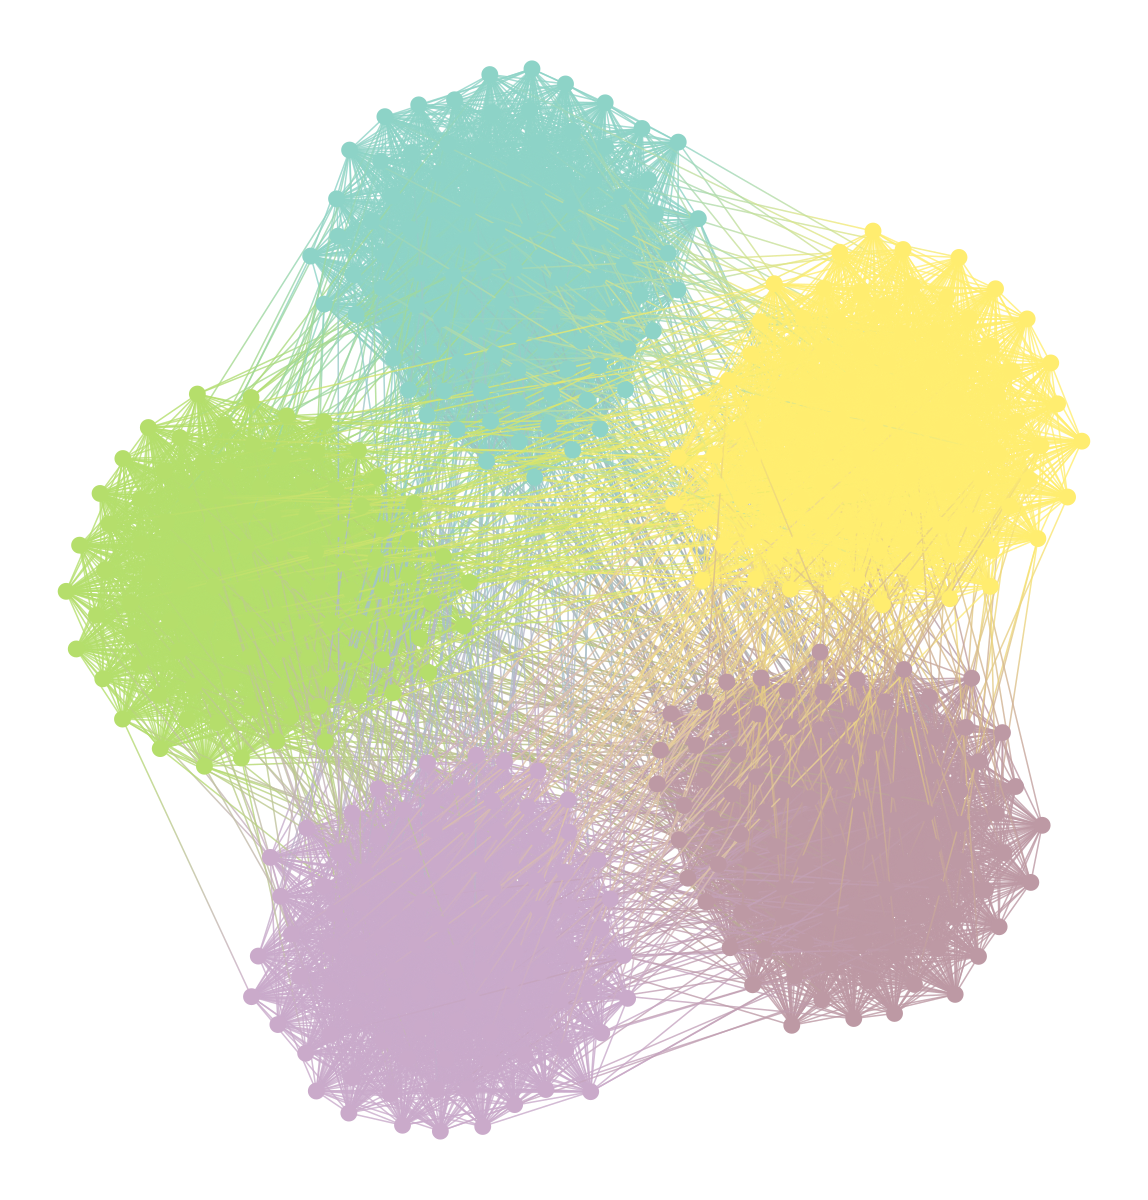

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6c79867b50, at 0x7f6c79848ac0>

In [14]:
state.draw()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


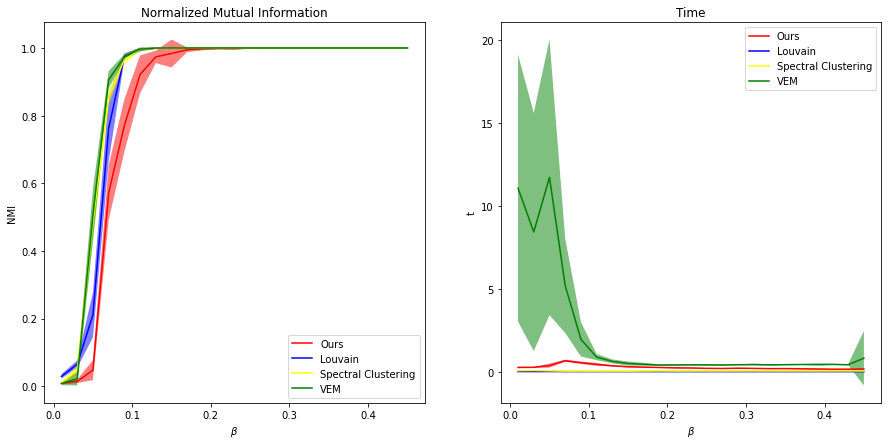

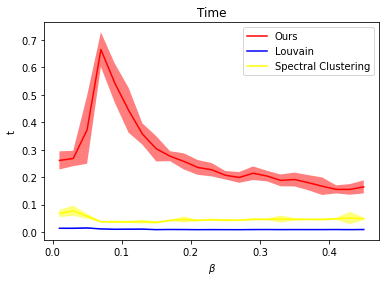

In [6]:
compareAlgos("./data/Communities",vem="mine",stop_var=False,stop_cheat=True)

In [7]:
n = 10000
K = 100
epsilon = 0.01

for i in range(5):
    for beta in np.arange(0.45,0,-0.1):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta
            P[K-1,j] = beta
            P[j,K-1] = beta
        P[K-1,K-1] = beta
        
        adj_sbm,lab_sbm = create_graph(P,[n//K for k in range(K)])
    
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

0
1
2
3
4


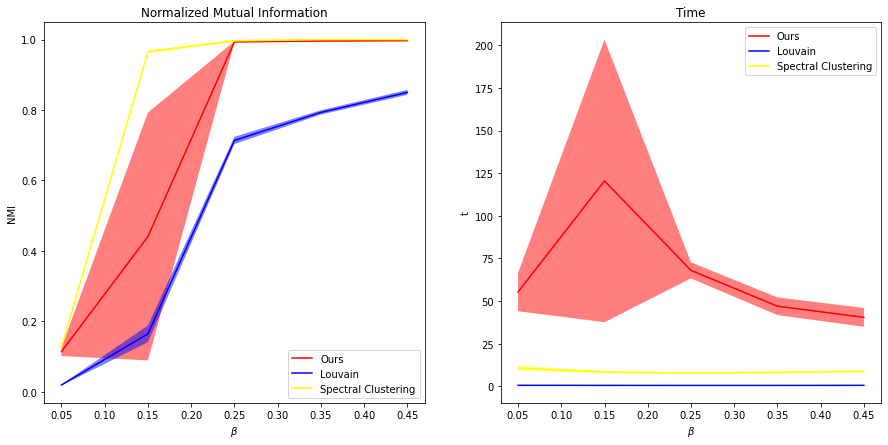

In [8]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


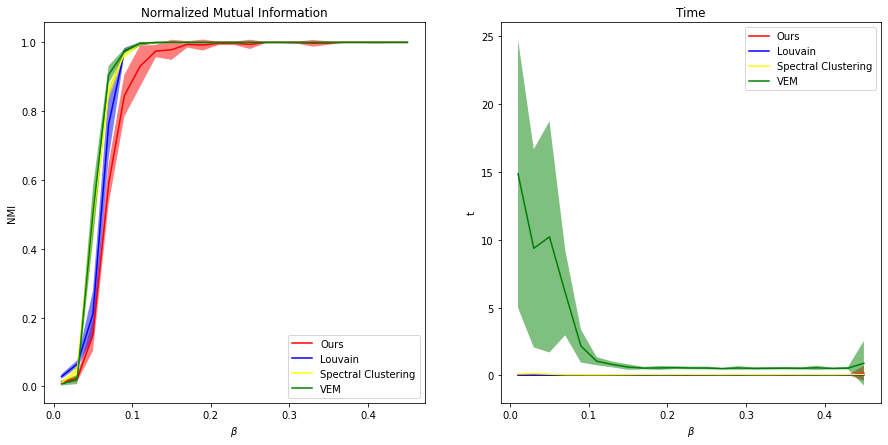

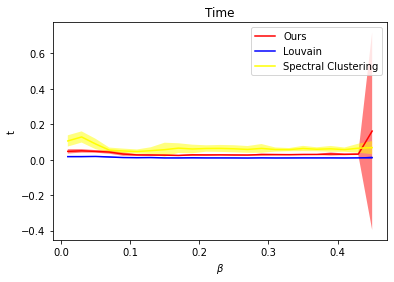

In [6]:
compareAlgos("./data/Communities",vem="mine",stop_var=True,stop_cheat=False)

0
1
2
3
4


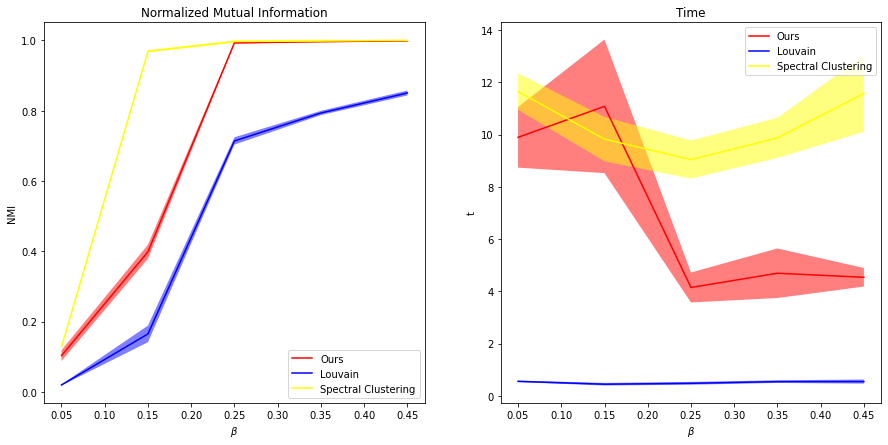

In [9]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",stop_var=True,stop_cheat=False,K=100)

#### Hub with equal proportions

In [7]:
path = "./data/HubsSame"
file = 0
beta = 0.45

data = np.loadtxt(path+"/sbm_"+str(file)+"_"+str(beta)+".csv",delimiter=',')
labels = data[:,0].astype(int)
adjacency = sp.sparse.csr_matrix(data[:,1:])

In [8]:
g = Graph(directed=False)
edge_list = []
for i in range(adjacency.shape[0]):
    for j in range(i):
        if adjacency[i,j]:
            edge_list.append((i,j))
g.add_edge_list(edge_list)

state = EMBlockState(g,B=5,init_state=BlockState(g,b=labels))

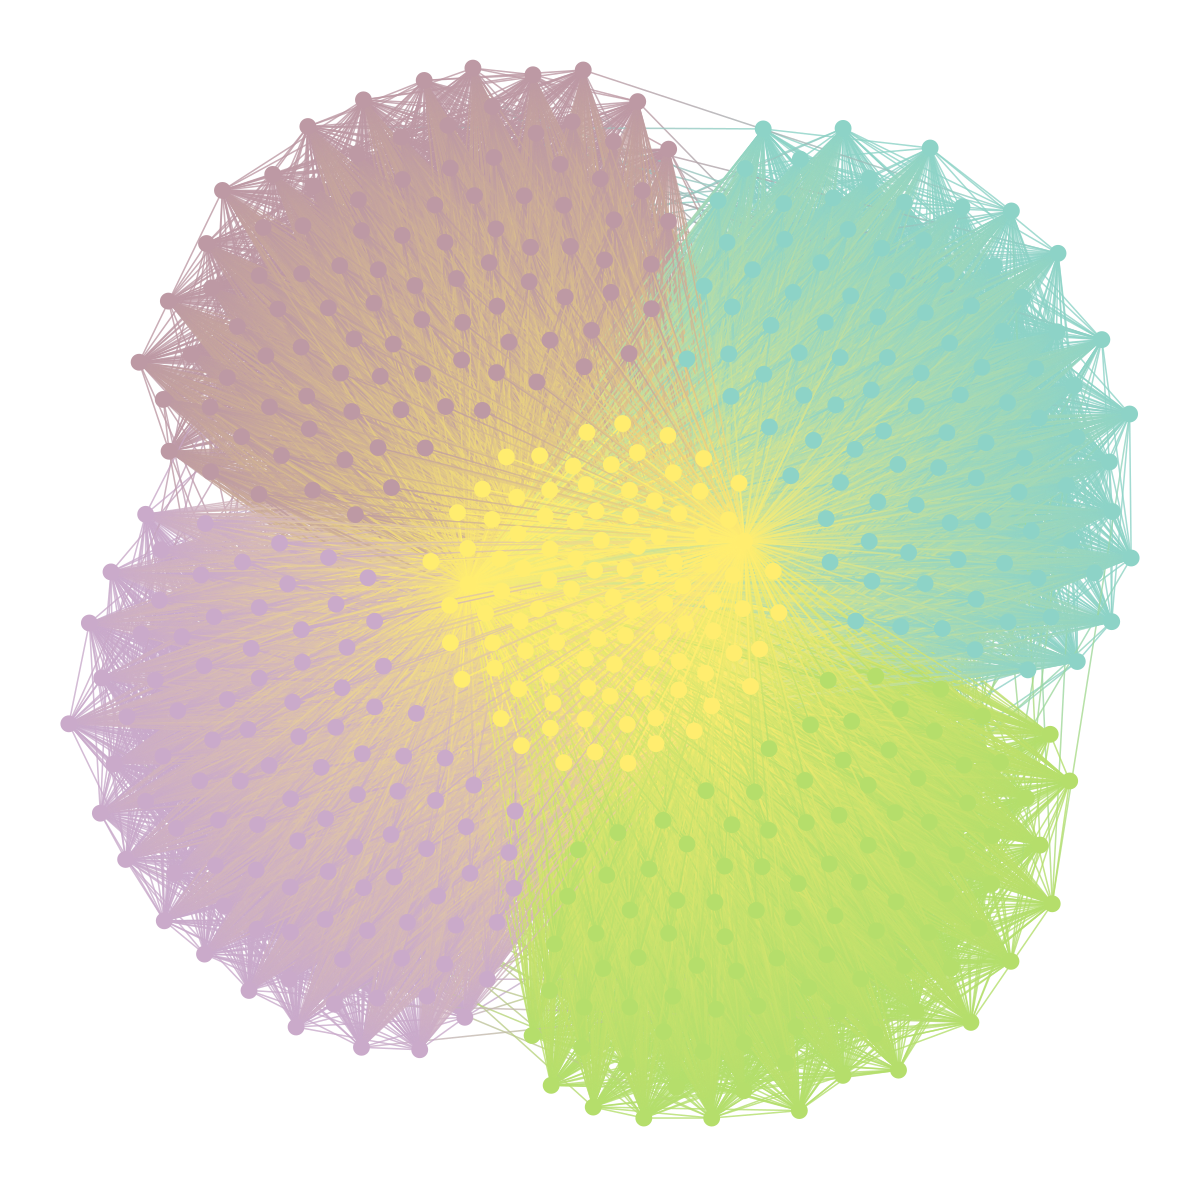

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd69749a9a0, at 0x7fd687a005e0>

In [9]:
state.draw()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


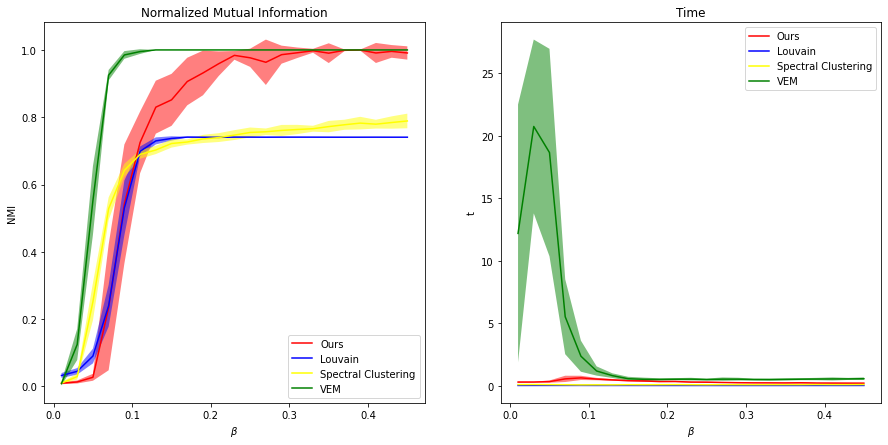

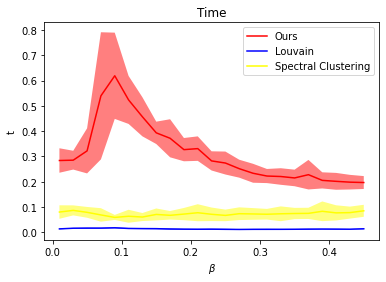

In [9]:
compareAlgos("./data/HubsSame",vem="mine",stop_var=False,stop_cheat=True)

In [6]:
n = 10000
K = 100
epsilon = 0.01

for i in range(5):
    for beta in np.arange(0.45,0,-0.1):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta
            P[K-1,j] = beta
            P[j,K-1] = beta
        P[K-1,K-1] = beta
            
        L = [int(n*0.9//(K-1)) for k in range(K-1)]
        L.append(int(n*0.1))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

0
1
2
3
4


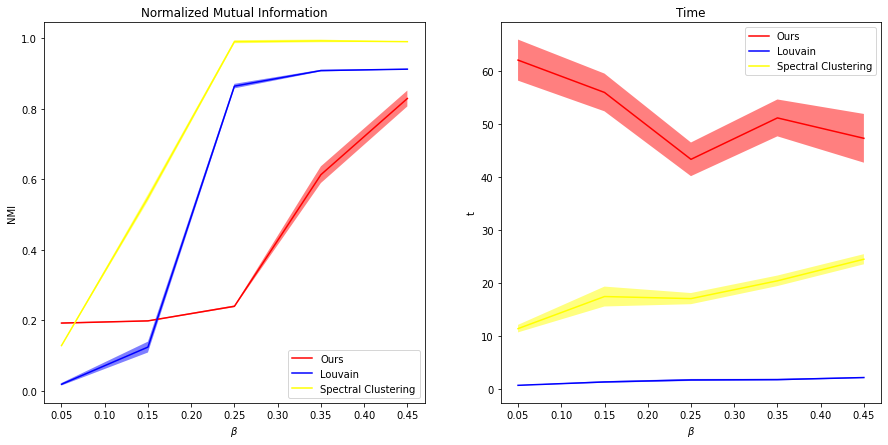

In [17]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100)

In [11]:
n = 10000
K = 100
epsilon = 0.01

for i in range(5):
    for beta in np.arange(0.45,0,-0.1):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta
            P[K-1,j] = beta
            P[j,K-1] = beta
        P[K-1,K-1] = beta
            
        L = [int(n*0.8//(K-1)) for k in range(K-1)]
        L.append(int(n*0.2))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

0
1
2
3
4


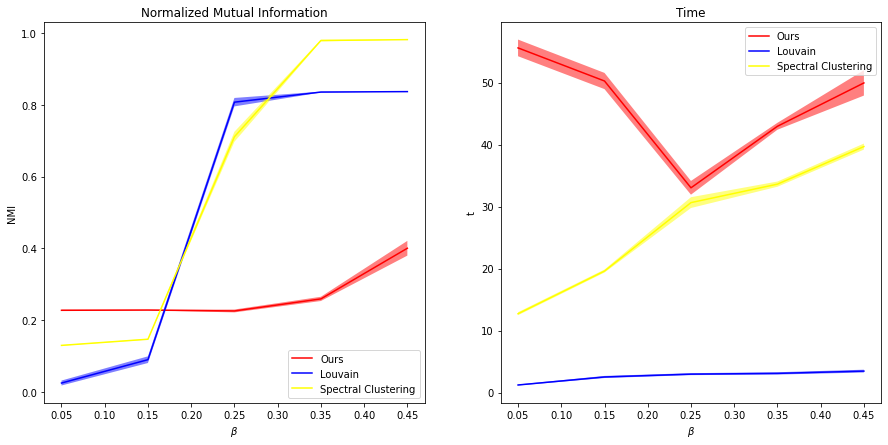

In [21]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


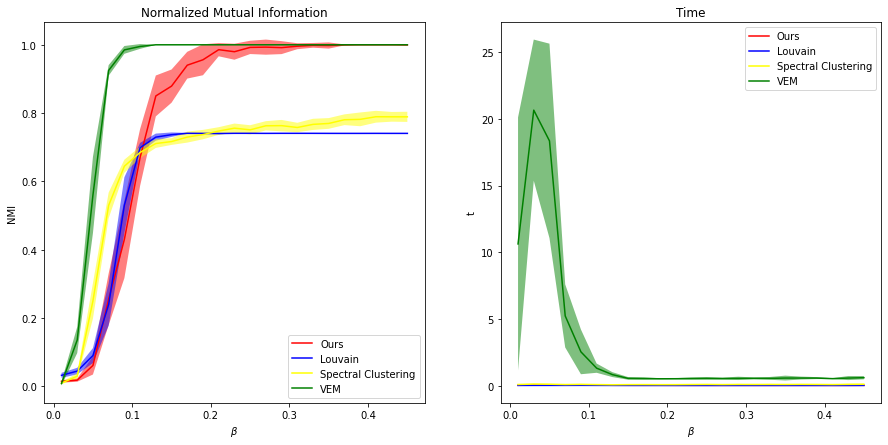

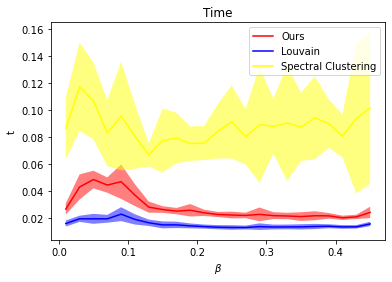

In [10]:
compareAlgos("./data/HubsSame",vem="mine",stop_var=True,stop_cheat=False)

0
1
2
3
4


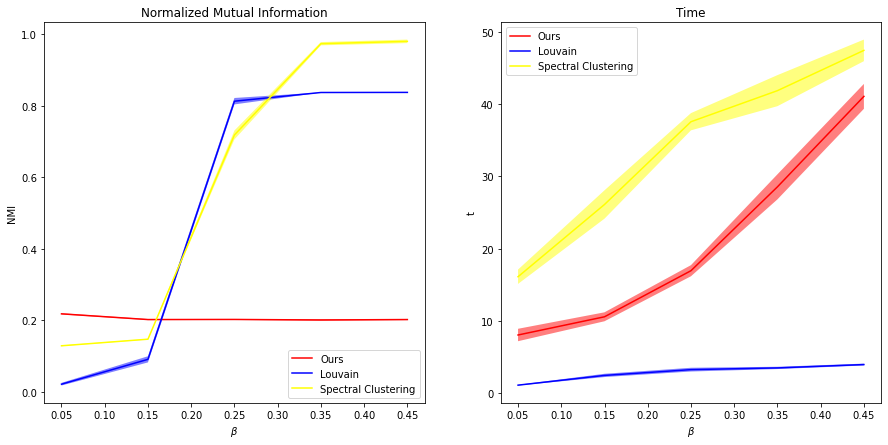

In [12]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100,stop_var=True,stop_cheat=False)

#### Communities + Star

In [12]:
path = "./data/Comm_Star"
file = 0
beta = 0.45

data = np.loadtxt(path+"/sbm_"+str(file)+"_"+str(beta)+".csv",delimiter=',')
labels = data[:,0].astype(int)
adjacency = sp.sparse.csr_matrix(data[:,1:])

In [13]:
g = Graph(directed=False)
edge_list = []
for i in range(adjacency.shape[0]):
    for j in range(i):
        if adjacency[i,j]:
            edge_list.append((i,j))
g.add_edge_list(edge_list)

state = EMBlockState(g,B=5,init_state=BlockState(g,b=labels))

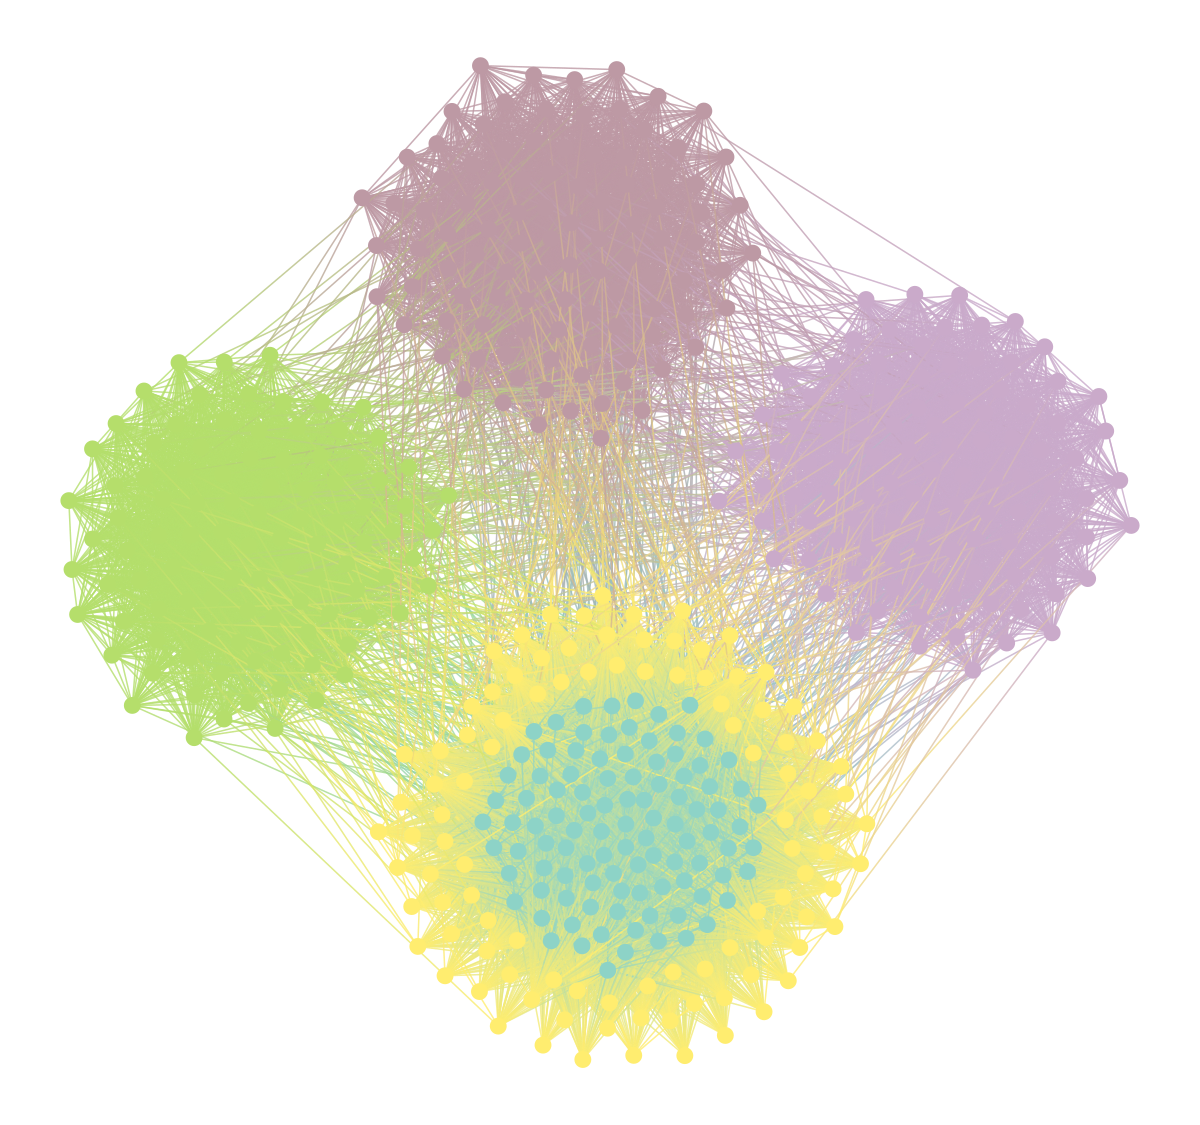

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe757c3a940, at 0x7fe75791d5b0>

In [14]:
state.draw()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


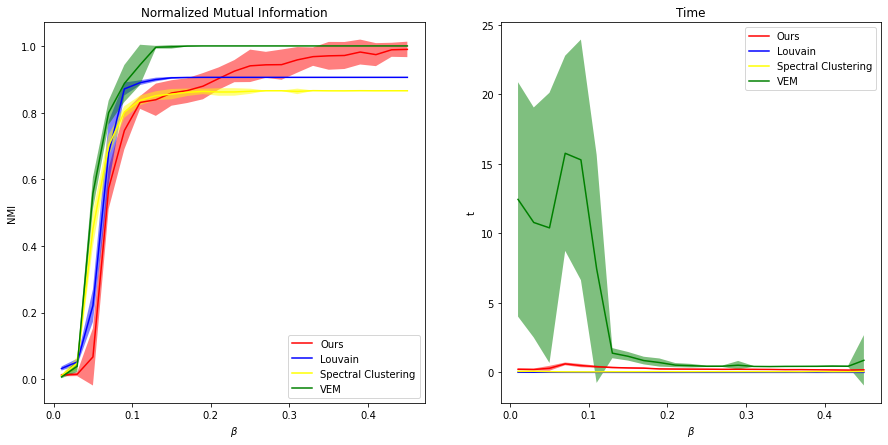

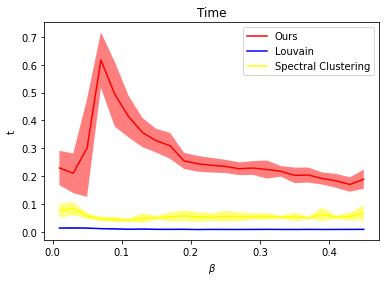

In [7]:
compareAlgos("./data/Comm_Star",vem="mine",stop_var=False,stop_cheat=True)

In [18]:
n = 10000
K = 100
epsilon = 0.01

for i in range(5):
    for beta in np.arange(0.45,0,-0.1):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta

        P[0,K-1] = beta
        P[K-1,0] = beta
            
        L = [int(n*0.9//(K-1)) for k in range(K-1)]
        L.append(int(n*0.1))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

0
1
2
3
4


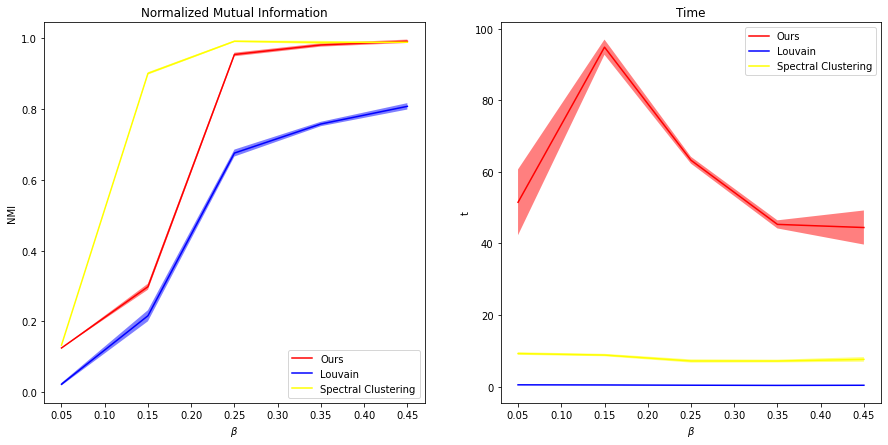

In [19]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest")

In [14]:
n = 10000
K = 100
epsilon = 0.01

for i in range(5):
    for beta in np.arange(0.45,0,-0.1):
        P = np.ones((K,K))*epsilon
        for j in range(K-1):
            P[j,j] = beta

        P[0,K-1] = beta
        P[K-1,0] = beta
            
        L = [int(n*0.8//(K-1)) for k in range(K-1)]
        L.append(int(n*0.2))
        
        adj_sbm,lab_sbm = create_graph(P,L)
    
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".csv",
                   np.concatenate([lab_sbm.reshape(-1,1),
                                   adj_sbm@np.eye(adj_sbm.shape[1])],
                                   axis=1),
                   delimiter=',')
        
        spm = get_edgelist(adj_sbm.indptr,adj_sbm.indices)
        np.savetxt("/mnt/Disque Dur 2 TO/DataTest/sbm_"+str(i)+"_"+str(beta)+".spm",spm)

0
1
2
3
4


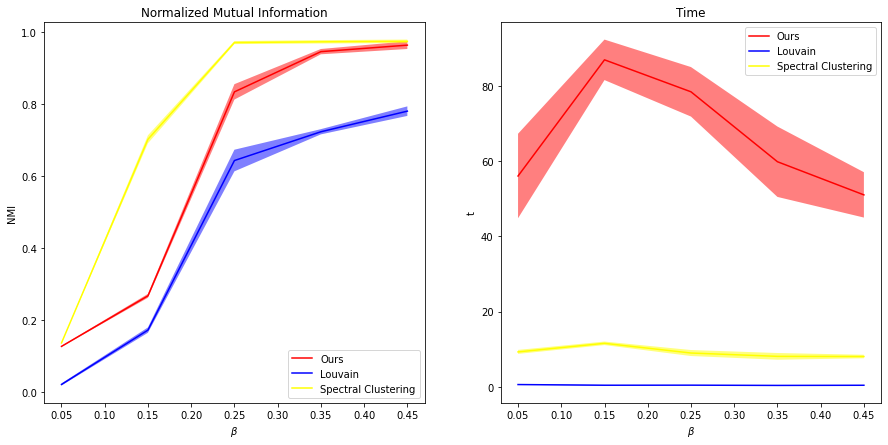

In [23]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


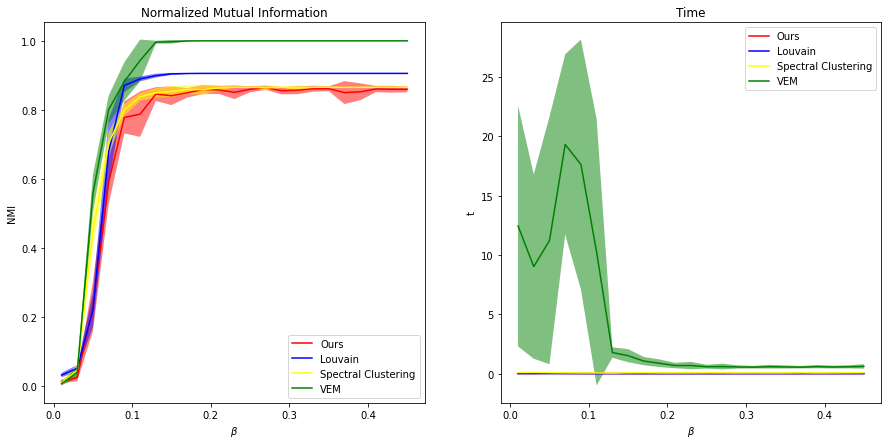

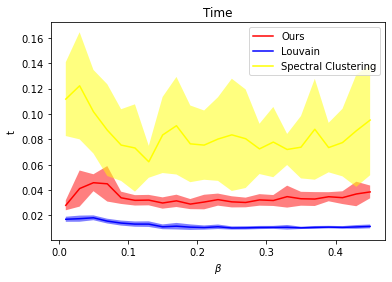

In [13]:
compareAlgos("./data/Comm_Star",vem="mine",stop_var=True,stop_cheat=False)

0
1
2
3
4


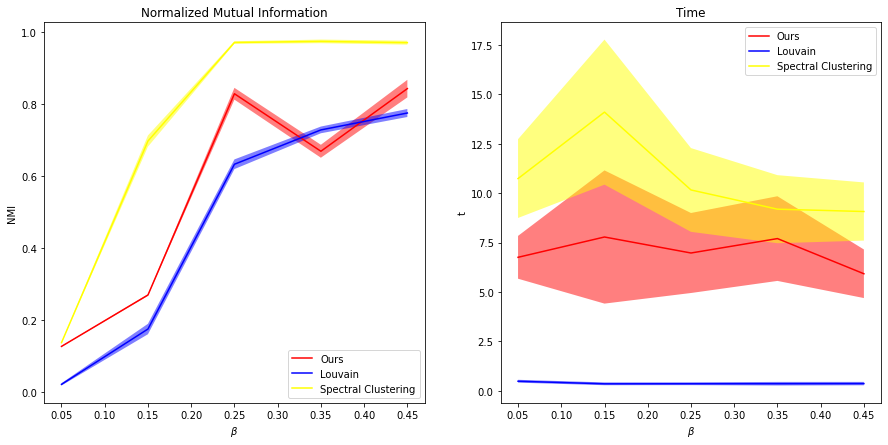

In [15]:
compareAlgos2("/mnt/Disque Dur 2 TO/DataTest",K=100,stop_var=True,stop_cheat=False)